Our training data is 59k, validation is 1k, and testing data is 10k

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

USE_GPU = False # Change to True when using UCSD Datahub
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cpu


In [2]:
NUM_TRAIN = 59000

transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.5,), (0.5,))
            ])

fashion_train = dset.FashionMNIST('datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(fashion_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

fashion_val = dset.FashionMNIST('datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(fashion_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

fashion_test = dset.FashionMNIST('datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(fashion_test, batch_size=64)

Visualizing some of the images (randomly):

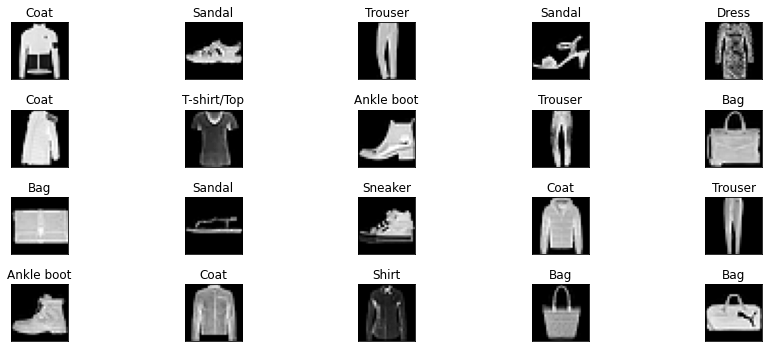

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def label_to_name(l):
    labels = ['T-shirt/Top', 'Trouser', 'Pullover', \
              'Dress', 'Coat', 'Sandal', 'Shirt', \
              'Sneaker', 'Bag', 'Ankle boot']
    return labels[l]

dataiter = iter(loader_train)
images, labels = dataiter.next()

fig = plt.figure(figsize=(15, 5))
for idx in range(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(label_to_name(labels[idx].item()))
    fig.tight_layout()

In [4]:
print('Images data dimension:', images.size())
print('Labels dimension:', labels.size())

Images data dimension: torch.Size([64, 1, 28, 28])
Labels dimension: torch.Size([64])


Note: Don't get confused. The `64` is due to we're specifying `batch_size=64` in the DataLoader. So, the loader, `loader_train`, loads 64 images, each of size 28x28 pixels (1 instead of 3 because it's not RGB)

### __Defining some helper functions and a training loop__

In [5]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [6]:
def train(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    loss_tracker = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            # x: img, y: label
            
            # Put model to training mode
            # because layers like dropout, batchnorm, etc. performs
            # differently in training and testing mode.
            model.train()  

            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y) # Change this maybe use MSELoss()?

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            # Book keeping for loss.
            loss_tracker.append(loss.item())
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()
    return loss_tracker

### __Defining the Conv. Neural Network model__

In [7]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
                
        self.fc1 = nn.Linear(in_features=2304, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=10)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

### __Training the model on training set__

In [8]:
# Hyperparameters (if any)
momentum = 0.9
learning_rate = 1e-2

Iteration 0, loss = 2.3081
Checking accuracy on validation set
Got 121 / 1000 correct (12.10)

Iteration 100, loss = 0.5471
Checking accuracy on validation set
Got 836 / 1000 correct (83.60)

Iteration 200, loss = 0.2781
Checking accuracy on validation set
Got 852 / 1000 correct (85.20)

Iteration 300, loss = 0.3189
Checking accuracy on validation set
Got 874 / 1000 correct (87.40)

Iteration 400, loss = 0.3771
Checking accuracy on validation set
Got 887 / 1000 correct (88.70)

Iteration 500, loss = 0.3928
Checking accuracy on validation set
Got 893 / 1000 correct (89.30)

Iteration 600, loss = 0.3349
Checking accuracy on validation set
Got 895 / 1000 correct (89.50)

Iteration 700, loss = 0.4017
Checking accuracy on validation set
Got 879 / 1000 correct (87.90)

Iteration 800, loss = 0.1390
Checking accuracy on validation set
Got 903 / 1000 correct (90.30)

Iteration 900, loss = 0.4172
Checking accuracy on validation set
Got 904 / 1000 correct (90.40)



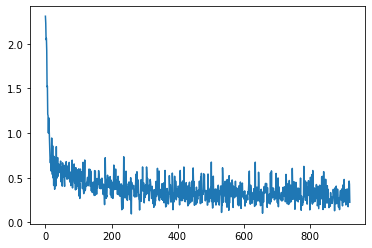

In [9]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
losses = train(model, optimizer)

plt.plot(list(range(len(losses))), losses)

### __Testing the model on testing set__

In [10]:
loss_test = 0.0
acc, total = 0, 0

for x, y in loader_test:
    if USE_GPU:
        x, y = x.cuda(), y.cuda() # in case we're unnecessarily using Datahub
    y_predicted = model(x)
    for yp, label in zip(torch.argmax(y_predicted, axis=1), y):
        if yp==label: acc+=1
        total+=1
    loss = F.cross_entropy(y_predicted, y)
    loss_test += loss.item() * x.size(0)

In [11]:
print('Testing Loss:', loss_test/len(loader_test))
print('Accurate Predictions:', acc/total)

Testing Loss: 20.034082078629996
Accurate Predictions: 0.8881


### __Some Visualizations__

In [12]:
def extract_predictions(model, loader):
    y_pred = torch.tensor([])
    for batch in loader:
        imgs, labels = batch
        batch_preds = model(imgs)
        y_pred = torch.cat((y_pred, batch_preds), dim=0)
    return y_pred

In [13]:
from sklearn.metrics import confusion_matrix

def plot_conf_mat(y_test, y_pred, classes, cmap):
    # Converting tensors to numpy array
    if not USE_GPU:
        y_test = fashion_test.targets.cpu().detach().numpy()
        y_pred = y_pred.cpu().detach().numpy()
    else:
        y_test = fashion_test.targets.gpu().detach().numpy()
        y_pred = y_pred.gpu().detach().numpy()

    # Create confusion matrix and normalize it
    conf_mat = confusion_matrix(y_test, y_pred.argmax(axis=1))
    conf_mat = conf_mat.astype('float')/conf_mat.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    
    # fig.tight_layout()
    return ax


<Figure size 3600x3600 with 0 Axes>

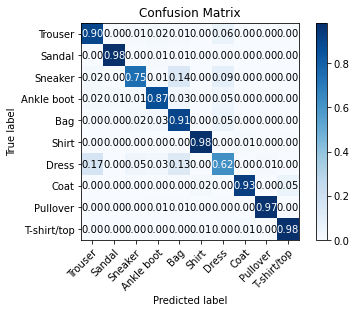

In [14]:
classes = {
 'T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot',    
}

y_test = fashion_test.targets
y_pred = extract_predictions(model, loader_test)
cmap = plt.cm.Blues

plt.figure(figsize=(50,50)) # Doesn't work
plot_conf_mat(y_test, y_pred, classes=classes, cmap=cmap)
plt.show()